# Model Definition

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertModel
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
TIMESTAMP = datetime.now().strftime("%Y%b%d%H%M").upper()

In [5]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'labels'

In [6]:
MAX_SEQUENCE_LENGTH = 512
NUM_LABELS = 5

MODEL_NAME = 'distilbert-base-uncased'
NUM_BASE_MODEL_OUTPUT = 768

# flag to freeze base model
FREEZE_BASE = True

In [7]:
# flag to add custom classification heads
USE_CUSTOM_HEAD = True
if USE_CUSTOM_HEAD == False:
    # make the base trainable when no classification head exists
    FREEZE_BASE = False

BATCH_SIZE = 16
LEARNING_RATE = 1e-4 if FREEZE_BASE else 5e-5
L2 = 0.01

In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors='pt'
    )

In [10]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = tokenize(self.texts[idx])
        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return input_ids, attention_mask, label

In [11]:
class CustomDistilBertModel(nn.Module):
    def __init__(self, base_model, num_labels, freeze_base=True, use_custom_head=True):
        super(CustomDistilBertModel, self).__init__()
        self.base_model = base_model
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False

        if use_custom_head:
            self.dropout = nn.Dropout(p=0.3)
            self.classifier = nn.Linear(NUM_BASE_MODEL_OUTPUT, num_labels)
        else:
            self.classifier = nn.Identity()

        self.use_custom_head = use_custom_head

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]
        if self.use_custom_head:
            hidden_state = self.dropout(hidden_state)
        logits = self.classifier(hidden_state)
        return logits

In [12]:
base_model = DistilBertModel.from_pretrained(MODEL_NAME)
model = CustomDistilBertModel(base_model, NUM_LABELS, freeze_base=FREEZE_BASE, use_custom_head=USE_CUSTOM_HEAD)
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CustomDistilBertModel(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (li

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2)

# Data Prep

In [14]:
# LOAD DATASET AND TRAIN

from datasets import load_dataset

dataset = load_dataset('gyoungjr/amazon-electronics-reviews')

train_data = pd.DataFrame(dataset["train"])
test_data = pd.DataFrame(dataset["test"])

Generating train split:   0%|          | 0/86932 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9660 [00:00<?, ? examples/s]

In [15]:
train_data.head()

,labels,text
0,2,My fault by trying to be cheap and buying wron...
1,1,Eh. This is one of those products that is gre...
2,2,"Bigger than expected, BUT that is my fault for..."
3,4,The bracket was just as advertised and worked ...
4,3,I love the size and shape. Wish it had s lil m...


In [16]:
# check for duplicated data
train_data.duplicated().sum()

4371

In [17]:
# check for null values
train_data.isnull().sum()

,0
labels,0
text,0


In [18]:
# remove special characters
# remove duplicates
# make sure types are correct
import re

def remove_special(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(text.split())
    return text

def clean_data(data):
    data["labels"] = data["labels"].astype(int)
    data["text"] = data["text"].astype(str)
    data.drop_duplicates(keep='last')
    data["text"].apply(remove_special)
    return data

train_data = clean_data(train_data)
test_data = clean_data(test_data)

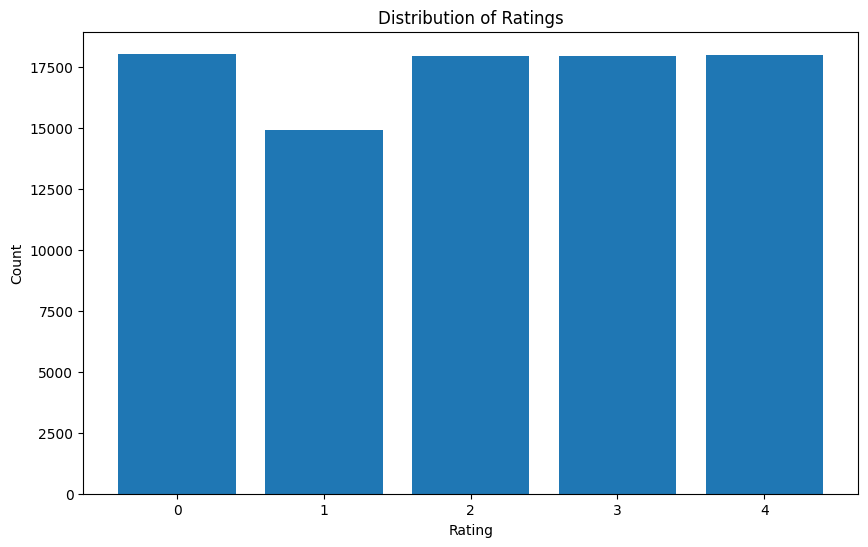

In [19]:
labels_count = train_data["labels"].value_counts()
labels_count

# check distribution of data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(labels_count.index, labels_count.values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [20]:
train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    train_data[DATA_COLUMN].tolist(),
    train_data[LABEL_COLUMN].tolist(),
    test_size=0.2,
    shuffle=True
)

In [21]:
train_texts[0]

'Performed comparably to Hulu 50 mile, but probably a little worse.'

In [22]:
train_dataset = CustomDataset(train_texts, train_labels)
validation_dataset = CustomDataset(validation_texts, validation_labels)

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

In [24]:
NUM_EPOCHS = 100

In [25]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

In [26]:
# Use only the first 100 samples for training
train_texts_subset = train_texts[:500]
train_labels_subset = train_labels[:500]
validation_texts_subset = validation_texts[:500]
validation_labels_subset = validation_labels[:500]

train_dataset_subset = CustomDataset(train_texts_subset, train_labels_subset)
validation_dataset_subset = CustomDataset(validation_texts_subset, validation_labels_subset)

train_dataloader_subset = DataLoader(train_dataset_subset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader_subset = DataLoader(validation_dataset_subset, batch_size=BATCH_SIZE)

In [29]:
#set device
model.to(device)

CustomDistilBertModel(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (li

In [30]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in validation_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
    avg_val_loss = total_val_loss / len(validation_dataloader)
    accuracy = correct_predictions / len(validation_dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Callbacks
    early_stopping_flag = early_stopping(avg_val_loss)

    if early_stopping_flag:
        print("Early stopping triggered.")
        break

Epoch 1/100, Train Loss: 1.2553
Validation Loss: 1.2143, Accuracy: 0.4873
Epoch 2/100, Train Loss: 1.2416
Validation Loss: 1.2075, Accuracy: 0.4882
Epoch 3/100, Train Loss: 1.2380
Validation Loss: 1.2021, Accuracy: 0.4909
Epoch 4/100, Train Loss: 1.2332
Validation Loss: 1.1971, Accuracy: 0.4954
Epoch 5/100, Train Loss: 1.2337
Validation Loss: 1.1970, Accuracy: 0.4906
Epoch 6/100, Train Loss: 1.2319
Validation Loss: 1.1959, Accuracy: 0.4957
Epoch 7/100, Train Loss: 1.2320
Validation Loss: 1.1959, Accuracy: 0.4943
Epoch 8/100, Train Loss: 1.2308
Validation Loss: 1.1940, Accuracy: 0.4935
Epoch 9/100, Train Loss: 1.2296
Validation Loss: 1.1974, Accuracy: 0.4923
Epoch 10/100, Train Loss: 1.2304
Validation Loss: 1.1949, Accuracy: 0.4927
Epoch 11/100, Train Loss: 1.2309
Validation Loss: 1.1945, Accuracy: 0.4924
Epoch 12/100, Train Loss: 1.2299
Validation Loss: 1.1945, Accuracy: 0.4968
Epoch 13/100, Train Loss: 1.2308
Validation Loss: 1.1960, Accuracy: 0.4939
Early stopping triggered.


In [31]:
# For prediction
comments = ["I hate your electronics", "Great Product!","I loveeeeeeeeeeee this","How disappointing!How do I just buy something and it is already malfunctioning","This is superb! Everyone needs this"]
tokenized_comments = tokenize(comments)
input_ids = tokenized_comments['input_ids'].to(device)
attention_mask = tokenized_comments['attention_mask'].to(device)

In [32]:
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    preds = torch.argmax(outputs, dim=1)
    probs = torch.softmax(outputs, dim=1)

for idx, prob in zip(preds, probs):
    print(f"Class index: {idx.item()}, Probability: {prob.max().item()}")

Class index: 0, Probability: 0.41987094283103943
Class index: 4, Probability: 0.8444244861602783
Class index: 4, Probability: 0.42364802956581116
Class index: 0, Probability: 0.6599235534667969
Class index: 4, Probability: 0.8460492491722107


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import transformers

In [35]:
torch.save(model.state_dict(), f'/content/drive/My Drive/G15_model_{TIMESTAMP}.pth')
tokenizer.save_pretrained("/content/drive/My Drive/G15_tokenizer")

('/content/drive/My Drive/G15_tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/G15_tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/G15_tokenizer/vocab.txt',
 '/content/drive/My Drive/G15_tokenizer/added_tokens.json',
 '/content/drive/My Drive/G15_tokenizer/tokenizer.json')